In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
#Other necessary imports
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import keras
from keras.preprocessing.image import ImageDataGenerator

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Data Understanding

In [3]:
#Find path for images and csv files
root_path = '../input/jpeg-melanoma-512x512/'
print(list(os.listdir(root_path)))

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']


In [4]:
#Read in training csv
df = pd.read_csv(root_path + 'train.csv')
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [5]:
#Look at DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
 8   tfrecord                       33126 non-null  int64  
 9   width                          33126 non-null  int64  
 10  height                         33126 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 2.8+ MB


In [6]:
#Check the number of nulls in each column
df.isna().sum()

image_name                         0
patient_id                         0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
tfrecord                           0
width                              0
height                             0
dtype: int64

In [7]:
#Check and see if any image names are duplicates
print(f"Does Image Name have any duplicates?: {df['image_name'].nunique() != len(df['image_name'])}")

Does Image Name have any duplicates?: False


In [8]:
#Check how many unique patients there are
print(f"Does Patient Id have any duplicates?: {df['patient_id'].nunique() != len(df['patient_id'])}")
df['patient_id'].nunique()

Does Patient Id have any duplicates?: True


2056

In [9]:
#Get the value counts by Sex
df['sex'].value_counts()

male      17080
female    15981
Name: sex, dtype: int64

In [10]:
df['sex'].value_counts(normalize=True)

male      0.516621
female    0.483379
Name: sex, dtype: float64

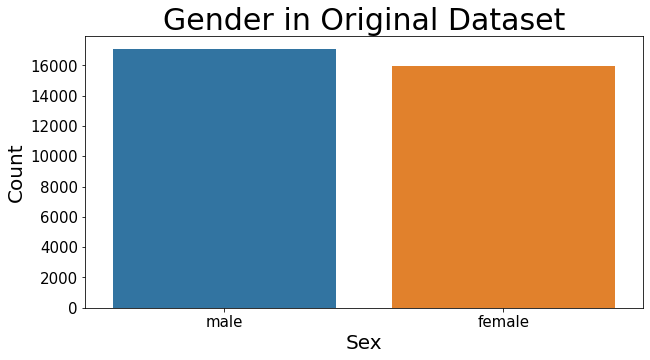

In [11]:
#Visualize the Gender distribution in the dataset
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df, x = 'sex')
ax.set_xlabel(xlabel = 'Sex', fontsize = 20)
ax.set_ylabel(ylabel = "Count", fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Gender in Original Dataset", fontsize = 30)
plt.show()

In [12]:
#Get value counts for age approximation
df['age_approx'].value_counts()

45.0    4466
50.0    4270
55.0    3824
40.0    3576
60.0    3240
35.0    2850
65.0    2527
30.0    2358
70.0    1968
25.0    1544
75.0     981
20.0     655
80.0     419
85.0     149
15.0     132
90.0      80
10.0      17
0.0        2
Name: age_approx, dtype: int64

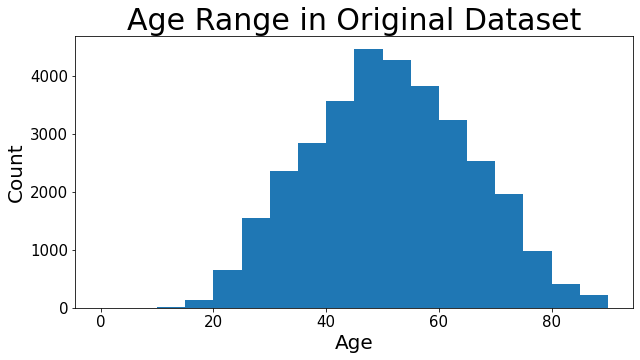

In [13]:
#Visualize Age approximation in dataset
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(df['age_approx'], bins = 18)
ax.set_xlabel(xlabel = 'Age', fontsize = 20)
ax.set_ylabel(ylabel = "Count", fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Age Range in Original Dataset", fontsize = 30)
plt.show()

In [14]:
#Get diagnosis value counts
df['diagnosis'].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

In [15]:
#Check if target only includes melanoma diagnosis
df[df['diagnosis']=='melanoma']['target'].value_counts()

1    584
Name: target, dtype: int64

In [16]:
df[df['diagnosis']!='melanoma']['target'].value_counts()

0    32542
Name: target, dtype: int64

Create a column for each path, jpeg and dicom <br>
Source: https://www.kaggle.com/andradaolteanu/siim-melanoma-competition-eda-augmentations#4.-Preprocess-.csv-files-%F0%9F%93%90

In [17]:
#Add a column with the path to each images jpeg
df['path_jpeg'] = root_path + 'train/' + df['image_name'] + '.jpg'
print(df['image_name'][0])
print(df['path_jpeg'][0])

ISIC_2637011
../input/jpeg-melanoma-512x512/train/ISIC_2637011.jpg


In [18]:
#Check target distribution
df['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [19]:
df['target'].value_counts(normalize=True)

0    0.98237
1    0.01763
Name: target, dtype: float64

In [20]:
#Check benign_malignant distribution
df['benign_malignant'].value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

In [21]:
#Double check that whenever target = 0, benign_malignant = 'benign', and vice versa
print(df[df['target']==0]['benign_malignant'].value_counts())
print(df[df['target']==1]['benign_malignant'].value_counts())

benign    32542
Name: benign_malignant, dtype: int64
malignant    584
Name: benign_malignant, dtype: int64


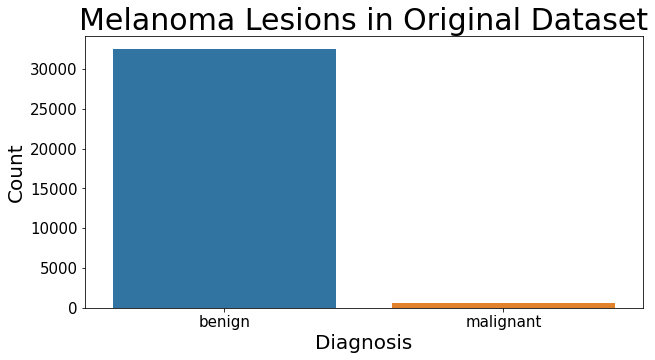

In [22]:
#Visualize Melanoma lesion distribution
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df, x = 'benign_malignant')
ax.set_xlabel(xlabel = 'Diagnosis', fontsize = 20)
ax.set_ylabel(ylabel = 'Count', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Melanoma Lesions in Original Dataset", fontsize = 30)
plt.show()

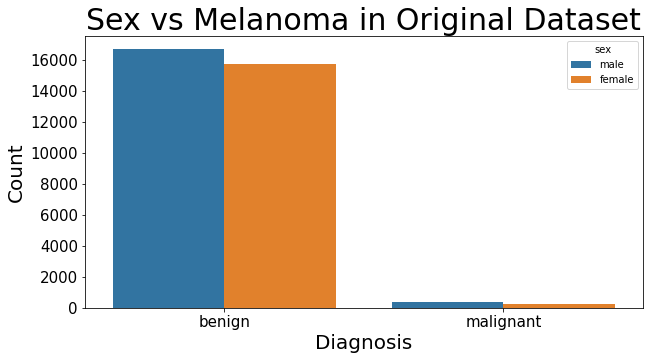

In [23]:
#Visualize Sex vs Melanoma Distribution
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df, x='benign_malignant', hue='sex')
ax.set_xlabel(xlabel = 'Diagnosis', fontsize = 20)
ax.set_ylabel(ylabel = 'Count', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Sex vs Melanoma in Original Dataset", fontsize = 30)
plt.show()

The target is heavily unbalanced. Let's add more malignant images from past competitions to help combat this.

Read in the 2019 data (includes images from 2018 and 2017 competitions) <br> Source: https://www.kaggle.com/cdeotte/jpeg-isic2019-512x512

In [24]:
#Read in 2019 dataset
df_2019 = pd.read_csv("../input/jpeg-isic2019-512x512/train.csv")
df_2019['path_jpeg'] = "../input/jpeg-isic2019-512x512/train/" + df_2019['image_name'] + ".jpg"
print(df_2019['path_jpeg'][0])

../input/jpeg-isic2019-512x512/train/ISIC_0000000.jpg


In [25]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     25331 non-null  object 
 1   patient_id                     25331 non-null  int64  
 2   sex                            25331 non-null  object 
 3   age_approx                     24894 non-null  float64
 4   anatom_site_general_challenge  22700 non-null  object 
 5   diagnosis                      25331 non-null  object 
 6   benign_malignant               25331 non-null  object 
 7   target                         25331 non-null  int64  
 8   tfrecord                       25331 non-null  int64  
 9   width                          25331 non-null  int64  
 10  height                         25331 non-null  int64  
 11  path_jpeg                      25331 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usag

In [26]:
#Print out the target distribution
print(df_2019['target'].value_counts())
print(df_2019['benign_malignant'].value_counts())

0    20809
1     4522
Name: target, dtype: int64
benign       20809
malignant     4522
Name: benign_malignant, dtype: int64


In [27]:
df_2019[df_2019['diagnosis']=='MEL']['benign_malignant'].value_counts()

malignant    4522
Name: benign_malignant, dtype: int64

In [28]:
#Create a new dataframe with only malignant images
df_2019_malignant = df_2019[df_2019['benign_malignant']=='malignant']
df_2019_malignant

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,path_jpeg
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,../input/jpeg-isic2019-512x512/train/ISIC_0000...
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,../input/jpeg-isic2019-512x512/train/ISIC_0000...
12,ISIC_0000013,-1,female,30.0,posterior torso,MEL,malignant,1,20,1022,767,../input/jpeg-isic2019-512x512/train/ISIC_0000...
21,ISIC_0000022_downsampled,-1,female,55.0,lower extremity,MEL,malignant,1,14,1024,768,../input/jpeg-isic2019-512x512/train/ISIC_0000...
25,ISIC_0000026_downsampled,-1,female,30.0,lower extremity,MEL,malignant,1,14,1024,768,../input/jpeg-isic2019-512x512/train/ISIC_0000...
...,...,...,...,...,...,...,...,...,...,...,...,...
25316,ISIC_0073231,-1,female,55.0,anterior torso,MEL,malignant,1,17,1024,1024,../input/jpeg-isic2019-512x512/train/ISIC_0073...
25319,ISIC_0073237,-1,female,45.0,lower extremity,MEL,malignant,1,11,1024,1024,../input/jpeg-isic2019-512x512/train/ISIC_0073...
25320,ISIC_0073238,-1,female,45.0,upper extremity,MEL,malignant,1,11,1024,1024,../input/jpeg-isic2019-512x512/train/ISIC_0073...
25322,ISIC_0073241,-1,male,60.0,palms/soles,MEL,malignant,1,13,1024,1024,../input/jpeg-isic2019-512x512/train/ISIC_0073...


Read in more jpg images that weren't from 2020,2019,2018, or 2017 <br> Source: https://www.kaggle.com/cdeotte/malignant-v2-1024x1024

In [29]:
#Add more malignant images that weren't used in 2020, 2019, 2018, or 2017 but were still on the ISIM website
df_more = pd.read_csv("../input/malignant-v2-512x512/train_malig_2.csv")
df_more['path_jpeg'] = "../input/malignant-v2-512x512/jpeg512/" + df_more['image_name'] + ".jpg"
print(df_more['path_jpeg'][0])

../input/malignant-v2-512x512/jpeg512/ISIC_0000070.jpg


In [30]:
df_more.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     580 non-null    object 
 1   patient_id                     580 non-null    int64  
 2   sex                            547 non-null    object 
 3   age_approx                     557 non-null    float64
 4   anatom_site_general_challenge  471 non-null    object 
 5   diagnosis                      554 non-null    object 
 6   benign_malignant               580 non-null    object 
 7   target                         580 non-null    int64  
 8   width                          580 non-null    int64  
 9   height                         580 non-null    int64  
 10  source                         580 non-null    object 
 11  ext                            580 non-null    object 
 12  tfrecord                       580 non-null    int

In [31]:
print(df_more['target'].value_counts())
print(df_more['benign_malignant'].value_counts())

1    580
Name: target, dtype: int64
malignant    580
Name: benign_malignant, dtype: int64


In [32]:
#Combine the 3 DataFrames into 1
df_combined = pd.concat([df, df_2019_malignant, df_more])
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38228 entries, 0 to 579
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     38228 non-null  object 
 1   patient_id                     38228 non-null  object 
 2   sex                            38130 non-null  object 
 3   age_approx                     38052 non-null  float64
 4   anatom_site_general_challenge  37465 non-null  object 
 5   diagnosis                      38202 non-null  object 
 6   benign_malignant               38228 non-null  object 
 7   target                         38228 non-null  int64  
 8   tfrecord                       38228 non-null  int64  
 9   width                          38228 non-null  int64  
 10  height                         38228 non-null  int64  
 11  path_jpeg                      38228 non-null  object 
 12  source                         580 non-null    o

In [33]:
#Check the value counts for benign or malignant images
df_combined['benign_malignant'].value_counts(normalize=True)

benign       0.851261
malignant    0.148739
Name: benign_malignant, dtype: float64

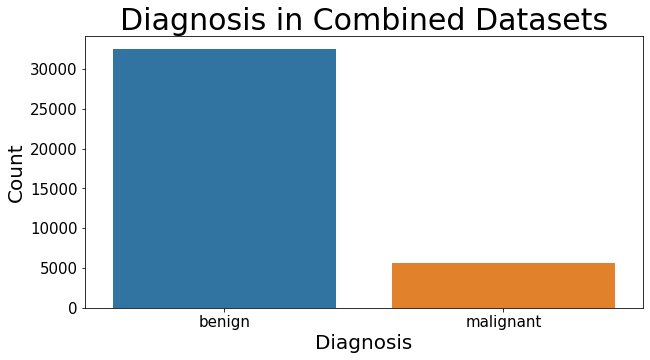

In [34]:
#Visualize the new distribution
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(data = df_combined, x = 'benign_malignant')
ax.set_xlabel(xlabel = 'Diagnosis', fontsize = 20)
ax.set_ylabel(ylabel = 'Count', fontsize = 20)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_title("Diagnosis in Combined Datasets", fontsize = 30)
plt.show()

# Train Test Split

In [35]:
#Make 2 Train test splits so that we are left with:
#X_train -> 67.5% of data
#X_val -> 22.5% of data
#X_test -> 10% of data
X = df_combined[['path_jpeg']]
y = df_combined['benign_malignant']
X_use, X_test, y_use, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_use, y_use, test_size=0.25, random_state=42, stratify=y_use)

In [36]:
#Combine the training data back together into 1 DataFrame
train_df = pd.concat([X_train, y_train], axis=1)
train_df

,path_jpeg,benign_malignant
32605,../input/jpeg-melanoma-512x512/train/ISIC_9843...,benign
20810,../input/jpeg-melanoma-512x512/train/ISIC_6322...,benign
28419,../input/jpeg-melanoma-512x512/train/ISIC_8600...,benign
1083,../input/jpeg-melanoma-512x512/train/ISIC_0429...,benign
15723,../input/jpeg-melanoma-512x512/train/ISIC_4807...,benign
...,...,...
5549,../input/jpeg-melanoma-512x512/train/ISIC_1758...,benign
12224,../input/jpeg-melanoma-512x512/train/ISIC_3761...,benign
4822,../input/jpeg-melanoma-512x512/train/ISIC_1548...,benign
19305,../input/jpeg-melanoma-512x512/train/ISIC_5863...,benign


In [37]:
#Combine the validation data back together into 1 DataFrame
val_df = pd.concat([X_val, y_val], axis=1)
val_df

,path_jpeg,benign_malignant
13964,../input/jpeg-melanoma-512x512/train/ISIC_4282...,benign
6875,../input/jpeg-melanoma-512x512/train/ISIC_2153...,benign
8167,../input/jpeg-melanoma-512x512/train/ISIC_2543...,benign
2475,../input/jpeg-melanoma-512x512/train/ISIC_0840...,benign
5880,../input/jpeg-melanoma-512x512/train/ISIC_1862...,benign
...,...,...
21344,../input/jpeg-melanoma-512x512/train/ISIC_6477...,benign
20959,../input/jpeg-melanoma-512x512/train/ISIC_6367...,benign
1006,../input/jpeg-melanoma-512x512/train/ISIC_0409...,benign
8070,../input/jpeg-isic2019-512x512/train/ISIC_0029...,malignant


In [38]:
#Combine the test data back together into 1 DataFrame
test_df = pd.concat([X_test, y_test], axis=1)
test_df

,path_jpeg,benign_malignant
14363,../input/jpeg-melanoma-512x512/train/ISIC_4398...,benign
20516,../input/jpeg-melanoma-512x512/train/ISIC_6244...,benign
15690,../input/jpeg-melanoma-512x512/train/ISIC_4794...,benign
22253,../input/jpeg-melanoma-512x512/train/ISIC_6742...,benign
5718,../input/jpeg-melanoma-512x512/train/ISIC_1812...,benign
...,...,...
3861,../input/jpeg-melanoma-512x512/train/ISIC_1262...,benign
28322,../input/jpeg-melanoma-512x512/train/ISIC_8574...,benign
1898,../input/jpeg-melanoma-512x512/train/ISIC_0668...,benign
27219,../input/jpeg-melanoma-512x512/train/ISIC_8244...,benign


In [39]:
#Double check target distribution in train DataFrame
train_df['benign_malignant'].value_counts(normalize=True)

benign       0.851258
malignant    0.148742
Name: benign_malignant, dtype: float64

In [40]:
#Double check target distribution in train DataFrame
val_df['benign_malignant'].value_counts(normalize=True)

benign       0.851314
malignant    0.148686
Name: benign_malignant, dtype: float64

# Visualize Images

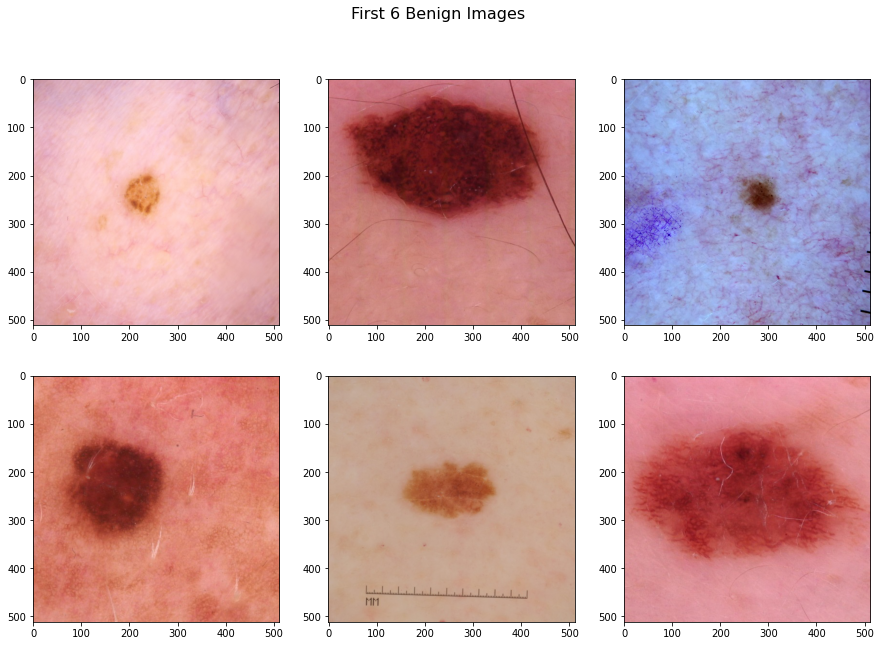

In [41]:
#Visualize the first 6 benign lesions in the training Dataframe
benign_df = train_df[train_df['benign_malignant']=='benign']
benign_images = benign_df['path_jpeg'][:6]
plt.figure(figsize=(15,10))
for i in range(6):
    plt.suptitle('First 6 Benign Images', fontsize = 16)
    plt.subplot(2,3,i+1)
    img = plt.imread(benign_images.iloc[i])
    plt.imshow(img)

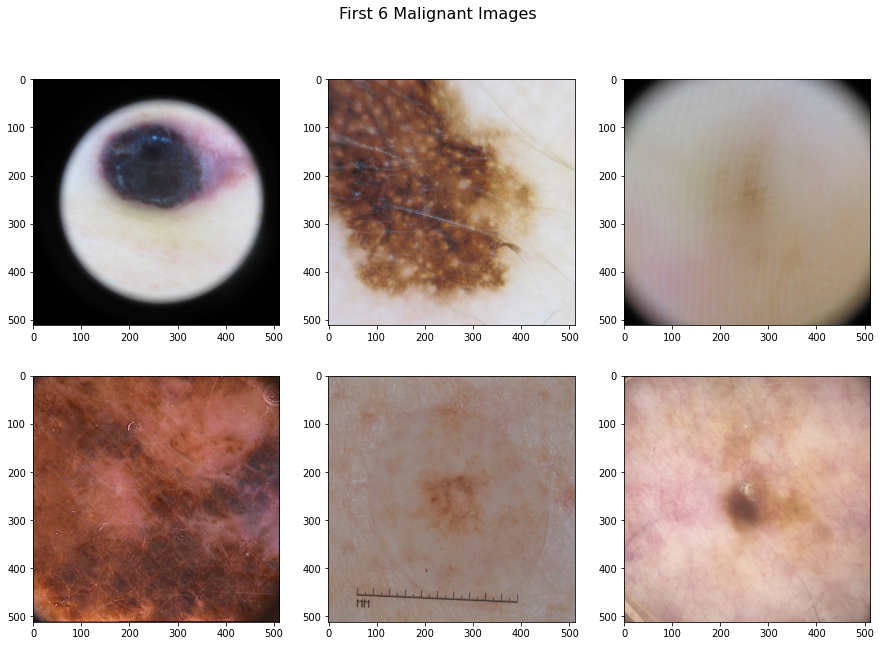

In [42]:
#Visualize the first 6 malignant lesions in the train DataFrame
malignant_df = train_df[train_df['benign_malignant']=='malignant']
malignant_images = malignant_df['path_jpeg'][:6]
plt.figure(figsize=(15,10))
for i in range(6):
    plt.suptitle('First 6 Malignant Images', fontsize = 16)
    plt.subplot(2,3,i+1)
    img = plt.imread(malignant_images.iloc[i])
    plt.imshow(img)

# Data Preprocessing

In [43]:
#Generate Image Data, resizing each image to 128x128
train_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(train_df, 
                                                                x_col='path_jpeg', 
                                                                y_col='benign_malignant',
                                                                seed=42,
                                                                target_size=(128, 128),
                                                                batch_size=len(X_train),
                                                                class_mode='binary') 
#For this ImageDataGenerator, divide the dataframe into 3 batches for conserve computer memory
train_generator_third = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(train_df, 
                                                                x_col='path_jpeg', 
                                                                y_col='benign_malignant',
                                                                seed=42,
                                                                target_size=(128, 128),
                                                                batch_size=int(len(X_train)/3),
                                                                class_mode='binary') 
val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                x_col='path_jpeg', 
                                                                y_col='benign_malignant',
                                                                seed=42,
                                                                target_size=(128, 128), 
                                                                batch_size = len(X_val),
                                                                class_mode='binary') 
test_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(test_df, 
                                                                x_col='path_jpeg',
                                                                y_col='benign_malignant',
                                                                seed=42,
                                                                target_size=(128, 128), 
                                                                batch_size = len(X_test),
                                                                class_mode='binary')  

Found 25803 validated image filenames belonging to 2 classes.
Found 25803 validated image filenames belonging to 2 classes.
Found 8602 validated image filenames belonging to 2 classes.
Found 3823 validated image filenames belonging to 2 classes.


In [44]:
#Create the data sets from the first batch 
train_images, train_labels = next(train_generator)
train_images_third, train_labels_third = next(train_generator_third)
val_images, val_labels = next(val_generator)
test_images, test_labels = next(test_generator)

In [45]:
#Checking classes
print("Train data set classes",train_generator.class_indices)
print("Validation data set classes",val_generator.class_indices)
print("Test data set classes",test_generator.class_indices)

Train data set classes {'benign': 0, 'malignant': 1}
Validation data set classes {'benign': 0, 'malignant': 1}
Test data set classes {'benign': 0, 'malignant': 1}


In [46]:
#Explore the dataset again
print ("Number of training samples: " + str(train_images.shape[0]))
print ("A third of training samples: " + str(train_images_third.shape[0]))
print ("Number of validation samples: " + str(val_images.shape[0]))
print ("Number of testing samples: " + str(test_images.shape[0]))
print ("")
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("A third of train_images shape: " + str(train_images_third.shape))
print ("A third of train_labels shape: " + str(train_labels_third.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training samples: 25803
A third of training samples: 8601
Number of validation samples: 8602
Number of testing samples: 3823

train_images shape: (25803, 128, 128, 3)
train_labels shape: (25803,)
A third of train_images shape: (8601, 128, 128, 3)
A third of train_labels shape: (8601,)
val_images shape: (8602, 128, 128, 3)
val_labels shape: (8602,)
test_images shape: (3823, 128, 128, 3)
test_labels shape: (3823,)


In [47]:
#Reduce memory space be converting to lower bit size
#Images went from float32 to float16
train_images = train_images.astype(np.float16)
train_images_third = train_images_third.astype(np.float16)
val_images = val_images.astype(np.float16)
test_images = test_images.astype(np.float16)

#Target went from float32 to int8
train_labels = train_labels.astype(np.uint8)
val_labels = val_labels.astype(np.uint8)
test_labels = test_labels.astype(np.uint8)

# Save Images and Labels

In [48]:
#Save images and labels
np.save("train_images", train_images)
np.save("train_labels", train_labels)

np.save("train_images_third", train_images_third)
np.save("train_labels_third", train_labels_third)

np.save("val_images", val_images)
np.save("val_labels", val_labels)

np.save("test_images", test_images)
np.save("test_labels", test_labels)